[0]	validation_0-rmse:40.73330	validation_1-rmse:43.80031
[100]	validation_0-rmse:21.56620	validation_1-rmse:21.84394
[200]	validation_0-rmse:15.45728	validation_1-rmse:15.50650
[300]	validation_0-rmse:13.08535	validation_1-rmse:13.82133
[400]	validation_0-rmse:11.83027	validation_1-rmse:13.33663
[500]	validation_0-rmse:11.08212	validation_1-rmse:13.12596
[600]	validation_0-rmse:10.50640	validation_1-rmse:13.04970
[650]	validation_0-rmse:10.26031	validation_1-rmse:13.05406
R^2: 0.7493
MAE: 10.06 gCO2/kWh


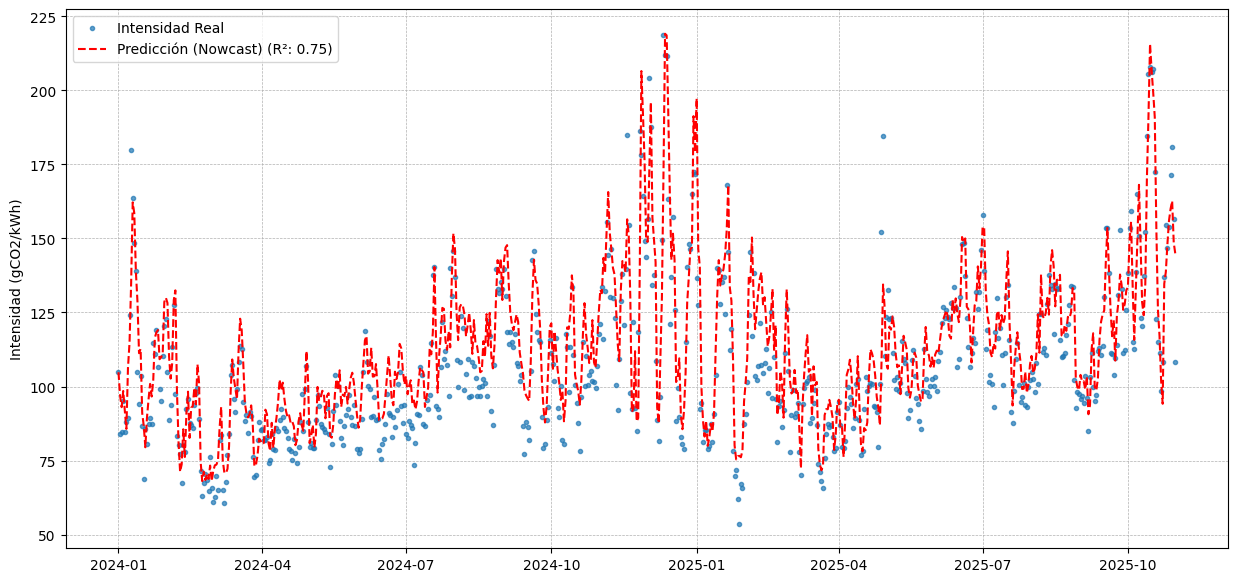

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import os
import sys

DATA_PATH = '../data/2_processed/dataset_maestro_5min.parquet'
df_5min = pd.read_parquet(DATA_PATH)
df_5min = df_5min.sort_index()

emisiones_5min = (
    (df_5min['cc'] * df_5min['factorEmisionCO2_cc']) +
    (df_5min['car'] * df_5min['factorEmisionCO2_car']) +
    (df_5min['cogenResto'] * df_5min['factorEmisionCO2_cogenResto']) +
    (df_5min['die'] * df_5min['factorEmisionCO2_die']) +
    (df_5min['gas'] * df_5min['factorEmisionCO2_gas']) +
    (df_5min['vap'] * df_5min['factorEmisionCO2_vap'])
)

emisiones_5min = emisiones_5min.fillna(0)

df_5min['intensidad_g_kWh'] = (emisiones_5min / df_5min['dem']) * 1000
df_5min['intensidad_g_kWh'] = df_5min['intensidad_g_kWh'].replace(
    [np.inf, -np.inf], np.nan
).fillna(0)

agg_dict = {
    'intensidad_g_kWh': 'mean',
    'temp_max_nacional_ponderada': 'first',
    'temp_min_nacional_ponderada': 'first',
    'viento_nacional_ponderado': 'first',
    'precipitacion_nacional_ponderada': 'first',
    'dia_año_sin': 'first',
    'dia_año_cos': 'first',
    'dia_semana_sin': 'first',
    'dia_semana_cos': 'first',
}
df_1d = df_5min.resample('D').agg(agg_dict)
df_1d = df_1d.rename(columns={'intensidad_g_kWh': 'intensidad_co2'})

try:
    df_omie_raw = pd.read_csv('../data/2_processed/spot_price.csv', delimiter=";", header=0)
    df_omie_raw['datetime_dt'] = pd.to_datetime(df_omie_raw['datetime'], utc=True)
    df_omie_proc = df_omie_raw[['datetime_dt', 'value']]
    df_omie = df_omie_proc.groupby(df_omie_proc['datetime_dt'].dt.date).mean(numeric_only=True)
    df_omie = df_omie.rename(columns={'value': 'precio_omie_diario'})
    df_omie.index = pd.to_datetime(df_omie.index)
except Exception as e:
    print(f"Error procesando CSV de ESIOS: {e}")
    sys.exit()

df_1d.index = df_1d.index.tz_localize(None) 
df_1d = df_1d.join(df_omie['precio_omie_diario'], how='inner')
df_1d = df_1d.dropna() 

col = 'intensidad_co2'
df_1d['intensidad_co2_lag_1d'] = df_1d['intensidad_co2'].shift(1)
df_1d['intensidad_co2_lag_2d'] = df_1d[col].shift(2)
df_1d['intensidad_co2_lag_7d'] = df_1d[col].shift(7)

df_1d['intensidad_co2_mean_7d'] = df_1d[col].shift(1).rolling(window=7).mean() 
df_1d['intensidad_co2_std_7d'] = df_1d[col].shift(1).rolling(window=7).std()

df_1d = df_1d.dropna() 

TARGET = 'intensidad_co2'
FEATURES = [
    'temp_max_nacional_ponderada',
    'temp_min_nacional_ponderada',
    'viento_nacional_ponderado',
    'precipitacion_nacional_ponderada',
    'dia_año_sin',
    'dia_año_cos',
    'dia_semana_sin',
    'dia_semana_cos',
    'precio_omie_diario',
    
    'lag_1d',
    'lag_2d',
    'lag_7d',
    'mean_7d',
    'std_7d'
]

X = df_1d[FEATURES]
y = df_1d[TARGET]

TEST_START_DATE_DIARIO = '2024-01-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]
X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_nowcast = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4, 
    objective='reg:squarederror', 
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_nowcast.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  verbose=100)

preds = model_nowcast.predict(X_test)
r2_final = r2_score(y_test, preds)
mae_final = mean_absolute_error(y_test, preds)

print(f"R^2: {r2_final:.4f}")
print(f"MAE: {mae_final:.2f} gCO2/kWh")

plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Intensidad real', 
         marker='.', linestyle='None', alpha=0.7)
plt.plot(y_test.index, preds, 
         label=f'Predicción (R²: {r2_final:.2f})', 
         linestyle='--', color='red')

plt.ylabel('Intensidad (gCO2/kWh)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()